# Differentiable Physics II:  Automatic Differentiation of Verlet Integration


Before we have used a simple force field which was defined as:

$$ F(x) = -kx $$

Moving forward we use a set of $K$ attractors each with a position $k_i$. The force function is then defined as:

$$ F(x) = \sum_{i=1}^N \frac{k_i - x}{||k_i - x||^2} $$

Finding the derivate of the force field is a bit more involved but it is still possible to do it analytically. However we can use an autograd library such as jax, to get the gradient of the loss of the solver. 

Text(0.5, 1.0, 'Randomly sampled attractors')

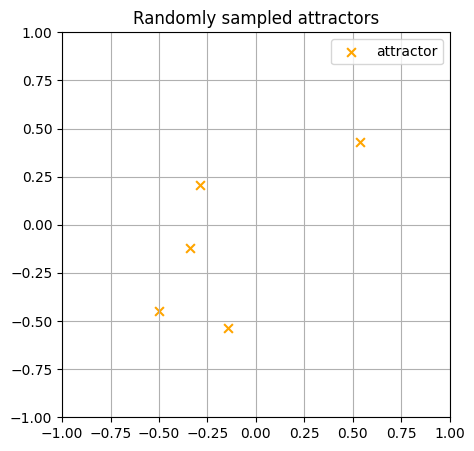

In [124]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import value_and_grad, jit, random
from jax.typing import ArrayLike

key = random.PRNGKey(0)

n_attractors = 5
attractors = random.uniform(key, (n_attractors, 2), minval=-1, maxval=1, dtype=jnp.float32)

plt.figure(figsize=(5,5))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid()

plt.scatter(attractors[:,0], attractors[:,1], c='orange', marker='x', s=40, label='attractor')
plt.legend()
plt.title('Randomly sampled attractors')


In [125]:
from typing import Callable

@jit
def force(x, attractors : ArrayLike):
    x_al = jnp.repeat(x.reshape(1,2), len(attractors), axis=0)
    vec = attractors - x_al

    d = jnp.sqrt(jnp.sum(vec ** 2, axis=1))

    f = jnp.sum(vec / d.reshape(-1,1), axis=0)

    return f

def verlet_step(
    x : ArrayLike,
    v : ArrayLike,
    dt : float,
    m : float, 
    force : Callable, 
    attractors : ArrayLike
    ) -> tuple[ArrayLike, ArrayLike]:
    dt2 = dt * dt
    x_fwd = x + v * dt + 0.5 * force(x, attractors) / m * dt2
    v_fwd = v + 0.5 * (force(x, attractors) + force(x_fwd, attractors)) * dt / m

    return x_fwd, v_fwd



A simple forward simulation of the system with 300 iterations:

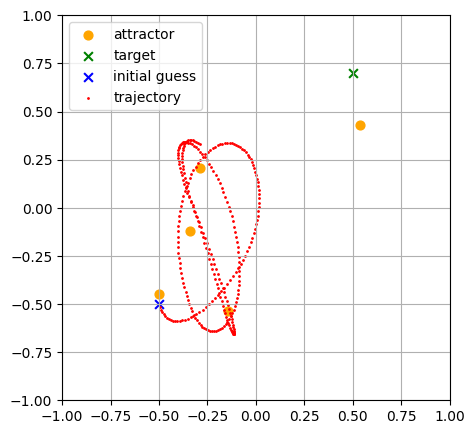

In [126]:
x0_guess = jnp.array([-0.5, -0.5], dtype=jnp.float32)
v0_guess = jnp.array([0.2, -0.8], dtype=jnp.float32)

xn_star = jnp.array([0.5, 0.7], dtype=jnp.float32)

n_iterations = 300
dt = 0.02
m = 1.0

x = x0_guess.copy()
v = v0_guess.copy()

xs = jnp.zeros((n_iterations, 2), dtype=jnp.float32)
vs = jnp.zeros((n_iterations, 2), dtype=jnp.float32)

for i in range(n_iterations):
    x, v = verlet_step(x, v, dt, m, force, attractors)
    xs = xs.at[i, :].set(x.copy())
    vs = vs.at[i, :].set(v.copy())

plt.figure(figsize=(5,5))

plt.xlim(-1,1)
plt.ylim(-1,1)

plt.grid()

plt.scatter(attractors[:,0], attractors[:,1], c='orange', marker='o', s=40, label='attractor')  
plt.scatter(xn_star[0], xn_star[1], c='green', marker='x', s=40, label='target')
plt.scatter(x0_guess[0], x0_guess[1], c='blue', marker='x', s=40, label='initial guess')
plt.scatter(xs[:,0], xs[:,1], c='red', marker='o', s=1, label='trajectory')

plt.legend()



To find the appropriate initial conditions we use the gradient descent method again. This time we perform all the differentiation using jit. 

In [127]:
def loss(x :  ArrayLike, target : ArrayLike) -> float:
    return jnp.mean((target - x) ** 2)

The actual simulation method:

In [128]:

def verlet_simulation(
        x0 : ArrayLike, 
        v0 : ArrayLike, 
        xn_star : ArrayLike,
        dt : float, 
        n : int, 
        m : float, 
        force : Callable, 
        attractors : ArrayLike) -> float:
    x = x0.copy()
    v = v0.copy()
    
    for _ in range(n):
        x, v = verlet_step(x, v, dt, m, force, attractors)

    return loss(x, xn_star)

Finally we use the ``value_and_grad`` method from jax to get the gradient and the actual loss value.

In [129]:
loss_grad = value_and_grad(verlet_simulation, argnums=(0, 1))

In [131]:
optimization_steps = 20

learning_rate = 0.8

x0 = x0_guess.copy()
v0 = v0_guess.copy()

losses = jnp.zeros(optimization_steps, dtype=jnp.float32)
x0s = jnp.zeros((optimization_steps, 2), dtype=jnp.float32)
v0s = jnp.zeros((optimization_steps, 2), dtype=jnp.float32)

for i in range(optimization_steps):

    loss_x, (grad_x, grad_v) = loss_grad(x0, v0, xn_star, dt, n_iterations, m, force, attractors)

    x0 -= learning_rate * grad_v
    v0 -= learning_rate * grad_v

    losses = losses.at[i].set(loss_x)
    x0s = x0s.at[i, :].set(x0.copy())
    v0s = v0s.at[i, :].set(v0.copy())

    print(F"loss {loss_x}")

loss 0.38059282302856445
loss 0.2801663875579834
loss 1.5798197984695435
loss 1.0168758630752563
loss 1.6932874917984009
loss 0.7377335429191589
loss 0.781364917755127
loss 2.2592382431030273
loss 0.1532171368598938
loss 0.225331649184227
loss 0.468065083026886
loss 1.4699639081954956
loss 0.32729455828666687
loss 0.36019229888916016
loss 0.12148968130350113
loss 0.046649836003780365
loss 0.06992681324481964
loss 0.06961030513048172
loss 0.13456280529499054
loss 0.009625708684325218


Text(0, 0.5, 'loss')

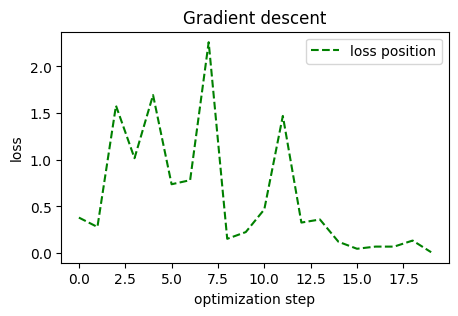

In [132]:
plt.figure(figsize=(5,3))

plt.plot(losses, label="loss position", color="green", linestyle="dashed")

plt.legend()

plt.title("Gradient descent")
plt.xlabel("optimization step")
plt.ylabel("loss")

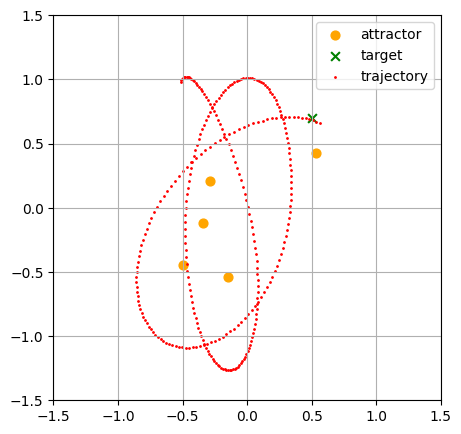

In [140]:
xs = jnp.zeros((n_iterations, 2), dtype=jnp.float32)
vs = jnp.zeros((n_iterations, 2), dtype=jnp.float32)

x = x0s[-1, :].copy()
v = v0s[-1, :].copy()

for i in range(n_iterations):
    x, v = verlet_step(x, v, dt, m, force, attractors)
    xs = xs.at[i, :].set(x.copy())
    vs = vs.at[i, :].set(v.copy())

plt.figure(figsize=(5,5))

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

plt.grid()

plt.scatter(attractors[:,0], attractors[:,1], c='orange', marker='o', s=40, label='attractor')  
plt.scatter(xn_star[0], xn_star[1], c='green', marker='x', s=40, label='target')
plt.scatter(xs[:,0], xs[:,1], c='red', marker='o', s=1, label='trajectory')

plt.legend()

